In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from models import cox_ph


import sys
sys.path.append("../")
from pathlib import Path
from Utils.Get_mvas import get_mvas_single_param, get_mvas_combined_params, get_events
from Utils.Combine_datasets import combine_mvas_adni, post_imputation_processing
from Utils.Data_imputation import impute_data, store_csv
from models import rubin_eval_cox, set_coef_test


# Importing datasets

In [2]:
#Load in the data
import yaml
path = '../Datasets/Imputed/MVAS+ADNI-B/'
folder_path = 'adni_mvas_b/'


conf_path = Path(f"{path}setup.yaml")
dfs_train = []
dfs_test = []

if not conf_path.exists():
        print('Configuration file not found')
        # return 1    
# else:
with open(conf_path) as f:
    config = yaml.safe_load(f)

columns_rm = ['COLPROT_1', 'COLPROT_MVAS_APOE4']
for i in range(config['num_datasets']):
    
    dfs_train.append(pd.read_csv(f"{path}/dataset_{i}/train.csv"))
    dfs_test.append(pd.read_csv(f"{path}/dataset_{i}/test.csv"))

pen_val=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

print(dfs_train[0].shape,"\n", dfs_train[0]['Event'].value_counts())
print(dfs_test[0].shape,"\n", dfs_test[0]['Event'].value_counts())

(232, 101) 
 Event
False    187
True      45
Name: count, dtype: int64
(59, 101) 
 Event
False    48
True     11
Name: count, dtype: int64


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(dfs_train[0].columns.to_list())

['PiB_SUVR_caudate',
 'SEPWI_CBF_caudate',
 'SEPWI_CBV_caudate',
 'SEPWI_CMRO2_caudate',
 'SEPWI_CTH_caudate',
 'SEPWI_OEF_caudate',
 'Volume_mm3_caudate',
 'PiB_SUVR_frontal_gm',
 'SEPWI_CBF_frontal_gm',
 'SEPWI_CBV_frontal_gm',
 'SEPWI_CMRO2_frontal_gm',
 'SEPWI_CTH_frontal_gm',
 'SEPWI_OEF_frontal_gm',
 'Volume_mm3_frontal_gm',
 'PiB_SUVR_frontal_wm',
 'SEPWI_CBF_frontal_wm',
 'SEPWI_CBV_frontal_wm',
 'SEPWI_CMRO2_frontal_wm',
 'SEPWI_CTH_frontal_wm',
 'SEPWI_OEF_frontal_wm',
 'Volume_mm3_frontal_wm',
 'PiB_SUVR_hippocampus',
 'SEPWI_CBF_hippocampus',
 'SEPWI_CBV_hippocampus',
 'SEPWI_CMRO2_hippocampus',
 'SEPWI_CTH_hippocampus',
 'SEPWI_OEF_hippocampus',
 'Volume_mm3_hippocampus',
 'PiB_SUVR_occipital_gm',
 'SEPWI_CBF_occipital_gm',
 'SEPWI_CBV_occipital_gm',
 'SEPWI_CMRO2_occipital_gm',
 'SEPWI_CTH_occipital_gm',
 'SEPWI_OEF_occipital_gm',
 'Volume_mm3_occipital_gm',
 'PiB_SUVR_occipital_wm',
 'SEPWI_CBF_occipital_wm',
 'SEPWI_CBV_occipital_wm',
 'SEPWI_CMRO2_occipital_wm',
 'SEPW

# Cox PH with penalty (Ridge)

In [4]:
cphs_ridge = []
variables_ridge = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, 
                                     verbose=False, l1_ratio=0.0,
                                     pen_val=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_ridge.append((c_index, penalizer))
    cphs_ridge.append(cph)

scores_ridge = [x[0] for x in variables_ridge]
print(f"Final score mean: {np.mean(scores_ridge)}\t std: {np.std(scores_ridge)}")
print(f"{np.mean(scores_ridge):.3f} $\pm$ {np.std(scores_ridge):.3f}")

Dataset 0
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6706586826347305, Penalizer: 0.5
Dataset 1
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6586826347305389, Penalizer: 0.5
Dataset 2
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7904191616766467, Penalizer: 0.2
Dataset 3
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7425149700598802, Penalizer: 0.3
Dataset 4
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.5718562874251497, Penalizer: 0.6
Dataset 5
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6497005988023952, Penalizer: 0.5
Dataset 6
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7754491017964071, Penalizer: 0.7
Dataset 7
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7095808383233533, Penalizer: 0.2
Dataset 8
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6497005988023952, Penalizer: 0.4
Dataset 9
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.8263473053892215, Penalizer: 0.3
Dataset 10

In [5]:
results_ridge = rubin_eval_cox(cphs_ridge)
display(results_ridge.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
SEPWI_CBF_frontal_wm,-0.319,0.727,1.204,-2.679,2.042,0.069,7.703,-0.265,0.791,0.338
Volume_mm3_hippocampus,-0.317,0.729,0.788,-1.861,1.227,0.156,3.412,-0.402,0.688,0.540
SEPWI_CMRO2_frontal_wm,-0.289,0.749,1.626,-3.476,2.898,0.031,18.144,-0.178,0.859,0.219
Volume_mm3_putamen,-0.240,0.787,0.681,-1.574,1.095,0.207,2.988,-0.352,0.725,0.464
SEPWI_OEF_occipital_gm,-0.149,0.861,2.422,-4.896,4.598,0.007,99.264,-0.062,0.951,0.073
PiB_SUVR_occipital_wm,-0.140,0.869,0.396,-0.916,0.635,0.400,1.888,-0.355,0.723,0.468
SEPWI_CBV_parietal_gm,-0.134,0.875,0.558,-1.227,0.960,0.293,2.611,-0.239,0.811,0.303
SEPWI_OEF_frontal_wm,-0.127,0.881,2.292,-4.620,4.365,0.010,78.673,-0.055,0.956,0.065
Volume_mm3_caudate,-0.105,0.901,0.741,-1.557,1.348,0.211,3.848,-0.141,0.888,0.172


In [6]:
coef_ridge = results_ridge['coef']
baseline_hazards = [indv_model.baseline_hazard_ for indv_model in cphs_ridge]
scores_c_ridge, scores_ipcw_ridge, scores_ibs_ridge = set_coef_test(coef_ridge, dfs_train, dfs_test, baseline_hazards)

print(f"Final C-index score mean: {np.mean(scores_c_ridge):.3f} $\pm$ {np.std(scores_c_ridge):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_ridge):.3f} $\pm$ {np.std(scores_ipcw_ridge):.3f}")
print(f"Final IBS C-index score mean: {np.mean(scores_ibs_ridge):.3f} $\pm$ {np.std(scores_ibs_ridge):.3f}")

Final C-index score mean: 0.715 $\pm$ 0.052
Final IPCW C-index score mean: 0.840 $\pm$ 0.042
Final IBS C-index score mean: 0.656 $\pm$ 0.015


# Cox PH with penalty (Lasso)

In [7]:
cphs_lasso = []
variables_lasso = []
pen_val_lasso=[0.05, 0.1, 0.2, 0.3]

for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, verbose=False, l1_ratio=1.0, pen_val=pen_val_lasso)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_lasso.append((c_index, penalizer))
    cphs_lasso.append(cph)
scores_lasso = [x[0] for x in variables_lasso]
print(f"Final score mean: {np.mean(scores_lasso)}\t std: {np.std(scores_lasso)}")
print(f"{np.mean(scores_lasso):.3f} $\pm$ {np.std(scores_lasso):.3f}")


Dataset 0
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6467065868263473, Penalizer: 0.05
Dataset 1
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6107784431137725, Penalizer: 0.1
Dataset 2
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.8532934131736527, Penalizer: 0.1
Dataset 3
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.688622754491018, Penalizer: 0.1
Dataset 4
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6856287425149701, Penalizer: 0.05
Dataset 5
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6526946107784432, Penalizer: 0.1
Dataset 6
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7844311377245509, Penalizer: 0.05
Dataset 7
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7425149700598802, Penalizer: 0.05
Dataset 8
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6107784431137725, Penalizer: 0.05
Dataset 9
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.718562874251497, Penalizer: 0.1
Dataset

In [8]:
results_lasso = rubin_eval_cox(cphs_lasso)
display(results_lasso.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MMSE,-0.077,0.926,0.082,-0.238,0.085,0.788,1.088,-0.930,0.352,1.505
Volume_mm3_hippocampus,-0.063,0.939,0.385,-0.817,0.691,0.442,1.997,-0.163,0.870,0.201
SEPWI_CBF_frontal_wm,-0.037,0.964,0.456,-0.931,0.858,0.394,2.358,-0.080,0.936,0.095
Volume_mm3_putamen,-0.032,0.969,0.243,-0.507,0.444,0.602,1.558,-0.131,0.896,0.159
SEPWI_CBV_frontal_gm,-0.014,0.986,0.215,-0.435,0.408,0.647,1.504,-0.063,0.950,0.075
SEPWI_CMRO2_frontal_gm,-0.010,0.990,0.141,-0.286,0.265,0.751,1.304,-0.073,0.942,0.087
RAVLT_immediate,-0.005,0.995,0.016,-0.037,0.027,0.963,1.027,-0.322,0.747,0.420
Volume_mm3_caudate,-0.004,0.996,0.256,-0.506,0.497,0.603,1.644,-0.017,0.987,0.019
Volume_mm3_parietal_gm,-0.003,0.997,0.330,-0.651,0.644,0.522,1.904,-0.010,0.992,0.012


In [9]:
coef_lasso = results_lasso['coef']
baseline_hazards_lasso = [indv_model.baseline_hazard_ for indv_model in cphs_lasso]
scores_c_lasso, scores_ipcw_lasso, scores_ibs_lasso = set_coef_test(coef_lasso, dfs_train, dfs_test, baseline_hazards_lasso)

print(f"Final C-index score mean: {np.mean(scores_c_lasso):.3f} $\pm$ {np.std(scores_c_lasso):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_lasso):.3f} $\pm$ {np.std(scores_ipcw_lasso):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ibs_lasso):.3f} $\pm$ {np.std(scores_ibs_lasso):.3f}")

Final C-index score mean: 0.706 $\pm$ 0.052
Final IPCW C-index score mean: 0.833 $\pm$ 0.037
Final IPCW C-index score mean: 0.196 $\pm$ 0.003


# Cox PH with penalty (Elastic net)

In [10]:
cphs_elastic = []
variables_elastic = []

for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, verbose=False, l1_ratio=0.5, pen_val=pen_val)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_elastic.append((c_index, penalizer))
    cphs_elastic.append(cph)
scores_elastic = [x[0] for x in variables_elastic]
print(f"Final score mean: {np.mean(scores_elastic)}\t std: {np.std(scores_elastic)}")
print(f"{np.mean(scores_elastic):.3f} $\pm$ {np.std(scores_elastic):.3f}")


Dataset 0
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6467065868263473, Penalizer: 0.2
Dataset 1
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6107784431137725, Penalizer: 0.6
Dataset 2
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.874251497005988, Penalizer: 0.3
Dataset 3
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6916167664670658, Penalizer: 0.2
Dataset 4
Train shape: (232, 101), Test shape: (59, 101)


c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=1.04404e-16): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=1.04909e-16): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=3.39628e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=2.78729e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packa

Score: 0.6347305389221557, Penalizer: 0.5
Dataset 5
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.655688622754491, Penalizer: 0.2
Dataset 6
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7754491017964071, Penalizer: 0.2
Dataset 7
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7604790419161677, Penalizer: 0.2
Dataset 8
Train shape: (232, 101), Test shape: (59, 101)


c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=1.06108e-16): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=8.27803e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=6.51302e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=4.94314e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packa

Score: 0.6916167664670658, Penalizer: 0.2
Dataset 9
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7335329341317365, Penalizer: 0.2
Dataset 10
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6497005988023952, Penalizer: 0.2
Dataset 11
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7904191616766467, Penalizer: 0.2
Dataset 12
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6497005988023952, Penalizer: 0.2
Dataset 13
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.6467065868263473, Penalizer: 0.2
Dataset 14
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.7514970059880239, Penalizer: 0.2
Dataset 15
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.718562874251497, Penalizer: 0.4
Dataset 16
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.688622754491018, Penalizer: 0.2
Dataset 17
Train shape: (232, 101), Test shape: (59, 101)
Score: 0.625748502994012, Penalizer: 0.2
Dataset 18
Train shape: (232, 101), Test shape: (59, 101)
Scor

In [11]:
results_elastic = rubin_eval_cox(cphs_elastic)
display(results_elastic.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MMSE,-0.048,0.953,0.063,-0.171,0.075,0.843,1.078,-0.766,0.444,1.172
RAVLT_immediate,-0.002,0.998,0.010,-0.021,0.017,0.980,1.017,-0.186,0.852,0.230
LDELTOTAL,-0.002,0.998,0.016,-0.033,0.030,0.967,1.030,-0.094,0.925,0.113
SEPWI_CMRO2_frontal_gm,-0.001,0.999,0.070,-0.138,0.136,0.871,1.146,-0.010,0.992,0.012
Volume_mm3_caudate,-0.000,1.000,0.190,-0.373,0.372,0.688,1.451,-0.002,0.998,0.003
Volume_mm3_hippocampus,-0.000,1.000,0.000,-0.001,0.001,0.999,1.001,-0.001,1.000,0.001
Volume_mm3_putamen,-0.000,1.000,0.000,-0.001,0.001,0.999,1.001,-0.000,1.000,0.001
SEPWI_CBV_parietal_gm,-0.000,1.000,0.000,-0.001,0.001,0.999,1.001,-0.000,1.000,0.001
SEPWI_CBF_frontal_wm,-0.000,1.000,0.001,-0.001,0.001,0.999,1.001,-0.000,1.000,0.000


In [12]:
coef_elastic = results_elastic['coef']
baseline_hazards_elastic = [indv_model.baseline_hazard_ for indv_model in cphs_elastic]
scores_c_elastic, scores_ipcw_elastic, scores_ibs_elastic = set_coef_test(coef_elastic, dfs_train, dfs_test, baseline_hazards_elastic)

print(f"Final C-index score mean: {np.mean(scores_c_elastic):.3f} $\pm$ {np.std(scores_c_elastic):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_elastic):.3f} $\pm$ {np.std(scores_ipcw_elastic):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ibs_elastic):.3f} $\pm$ {np.std(scores_ibs_elastic):.3f}")

Final C-index score mean: 0.698 $\pm$ 0.051
Final IPCW C-index score mean: 0.829 $\pm$ 0.035
Final IPCW C-index score mean: 0.233 $\pm$ 0.000


# RSF

In [13]:
from models import survival_forest

rsfs = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):

    rsf, score, score_ipcw, score_bri = survival_forest(df_train, df_test, cross_validate=True, verbose=False)
    print(score)

    print(score, score_ipcw[0], score_bri)
    
    rsfs.append((rsf, score, score_ipcw[0], score_bri))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.7095808383233533
0.7095808383233533 0.7690780001340755 0.1489776640526216
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 400}
0.7005988023952096
0.7005988023952096 0.7625963795688294 0.13687263778089107
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 200}
0.8203592814371258
0.8203592814371258 0.8649828249754146 0.11773552240861651
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 300}
0.8682634730538922
0.8682634730538922 0.8931585680698745 0.1321593146759715
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_

In [14]:
scores_c_rsf = [x[1] for x in rsfs]
scores_ipcw_rsf = [x[2] for x in rsfs]
scores_ibs_rsf = [x[3] for x in rsfs]
print(f"C-index mean: {np.mean(scores_c_rsf):.3f} $\pm$ {np.std(scores_c_rsf):.3f}")
print(f"IPCW-C mean: {np.mean(scores_ipcw_rsf):.3f} $\pm$ {np.std(scores_ipcw_rsf):.3f}")
print(f"IBS mean: {np.mean(scores_ibs_rsf):.3f} $\pm$ {np.std(scores_ibs_rsf):.3f}")

C-index mean: 0.754 $\pm$ 0.052
IPCW-C mean: 0.844 $\pm$ 0.062
IBS mean: 0.134 $\pm$ 0.010


# Summary of scores

In [15]:
print("C-index:")
print(f"Ridge: {np.mean(scores_c_ridge):.3f} $\pm$ {np.std(scores_c_ridge):.3f}")
print(f"Lasso: {np.mean(scores_c_lasso):.3f} $\pm$ {np.std(scores_c_lasso):.3f}")
print(f"Elastic: {np.mean(scores_c_elastic):.3f} $\pm$ {np.std(scores_c_elastic):.3f}")
print(f"RSF: {np.mean(scores_c_rsf):.3f} $\pm$ {np.std(scores_c_rsf):.3f}")

print()
print("IPCW C:")
print(f"Ridge: {np.mean(scores_ipcw_ridge):.3f} $\pm$ {np.std(scores_ipcw_ridge):.3f}")
print(f"Lasso: {np.mean(scores_ipcw_lasso):.3f} $\pm$ {np.std(scores_ipcw_lasso):.3f}")
print(f"Elastic: {np.mean(scores_ipcw_elastic):.3f} $\pm$ {np.std(scores_ipcw_elastic):.3f}")
print(f"RSF: {np.mean(scores_ipcw_rsf):.3f} $\pm$ {np.std(scores_ipcw_rsf):.3f}")

print()
print("IBS:")
print(f"Ridge: {np.mean(scores_ibs_ridge):.3f} $\pm$ {np.std(scores_ibs_ridge):.3f}")
print(f"Lasso: {np.mean(scores_ibs_lasso):.3f} $\pm$ {np.std(scores_ibs_lasso):.3f}")
print(f"Elastic: {np.mean(scores_ibs_elastic):.3f} $\pm$ {np.std(scores_ibs_elastic):.3f}")
print(f"RSF: {np.mean(scores_ibs_rsf):.3f} $\pm$ {np.std(scores_ibs_rsf):.3f}")


C-index:
Ridge: 0.715 $\pm$ 0.052
Lasso: 0.706 $\pm$ 0.052
Elastic: 0.698 $\pm$ 0.051
RSF: 0.754 $\pm$ 0.052

IPCW C:
Ridge: 0.840 $\pm$ 0.042
Lasso: 0.833 $\pm$ 0.037
Elastic: 0.829 $\pm$ 0.035
RSF: 0.844 $\pm$ 0.062

IBS:
Ridge: 0.656 $\pm$ 0.015
Lasso: 0.196 $\pm$ 0.003
Elastic: 0.233 $\pm$ 0.000
RSF: 0.134 $\pm$ 0.010


# RSF importance

In [16]:
from sklearn.inspection import permutation_importance
from sksurv.datasets import get_x_y
random_state = 42
pd.options.display.float_format = '{:.5f}'.format


importance = []
for rsf, (df_train, df_test) in zip(rsfs, zip(dfs_train, dfs_test)):
    x_test, y_test = get_x_y(df_test, attr_labels=["Event", "M"], pos_label=1)
    result = permutation_importance(rsf[0], x_test, y_test, n_repeats=15, n_jobs=-1, random_state=random_state)
    importance.append(result)
    df_res = pd.DataFrame(
        {
            k: result[k]
            for k in (
                "importances_mean",
                "importances_std",
            )
        },
        index=x_test.columns,
    ).sort_values(by="importances_mean", ascending=False)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    # display(df_res.head(15))

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_colwidth')

In [17]:
all_importances = np.array([var['importances_mean'] for var in importance])
all_variances = np.array([var['importances_std'] for var in importance])

In [18]:
Q_bar = np.mean(all_importances, axis=0)  # Pooled importance means
U_bar = np.mean(all_variances, axis=0)    # Within-imputation variances
B = np.var(all_importances, axis=0, ddof=1)  # Between-imputation variances
from scipy.stats import norm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# Total variance
T = U_bar + (1 + 1/len(rsfs)) * B

# Standard errors
se = np.sqrt(T)

# Confidence intervals
alpha = 0.05
z_value = norm.ppf(1 - alpha / 2)
ci_lower = Q_bar - z_value * se
ci_upper = Q_bar + z_value * se

# Combine results into a DataFrame for easy viewing
feature_names = x_test.columns
results_rsf = pd.DataFrame({
    'importance_mean': Q_bar,
    'importance_se': se,
    'importance_ci_lower': ci_lower,
    'importance_ci_upper': ci_upper
}, index=feature_names)

# Sort by mean importance
results_rsf = results_rsf.sort_values(by='importance_mean')

display(results_rsf)

,importance_mean,importance_se,importance_ci_lower,importance_ci_upper
MOCA,-0.00487,0.08028,-0.16222,0.15248
ADASQ4,-0.00458,0.12259,-0.24486,0.23570
LDELTOTAL,-0.00336,0.09788,-0.19521,0.18848
Volume_mm3_thalamus,-0.00151,0.08433,-0.16680,0.16378
SEPWI_CBV_temporal_wm,-0.00137,0.05771,-0.11447,0.11174
SEPWI_CBV_frontal_wm,-0.00131,0.05803,-0.11504,0.11242
SEPWI_CBF_frontal_wm,-0.00121,0.05323,-0.10553,0.10312
AGE,-0.00101,0.05513,-0.10906,0.10705
SEPWI_CBF_occipital_gm,-0.00086,0.04956,-0.09800,0.09627
SEPWI_CBF_occipital_wm,-0.00085,0.05962,-0.11770,0.11599


# Plots

In [19]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


font_path = '../Old_Standard_TT'
font_path_regular = f'{font_path}/OldStandardTT-Regular.ttf'
font_path_bold = f'{font_path}/OldStandardTT-Bold.ttf'
font_path_italic = f'{font_path}/OldStandardTT-Italic.ttf'

# Specify the direct path to your font file
# font_path_regular = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Regular.ttf'
# font_path_bold = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Bold.ttf'
# font_path_italic = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Italic.ttf'
# Create a FontProperties object with the full path to the font file
prop_regular = FontProperties(fname=font_path_regular)
prop_bold = FontProperties(fname=font_path_bold)
prop_italic = FontProperties(fname=font_path_italic)
my_colors = ['#B0DAFF', '#FFB085']
def plot_errorbars(coef, ci_lower, ci_upper, path, title, yticks, figsize=(12, 10)):
    # Create an array for the positions on the y-axis
    y_pos = np.arange(len(coef))

    fig, ax = plt.subplots(figsize=figsize)

    # Plot the points with error bars
    ax.errorbar(coef, y_pos, xerr=[coef - ci_lower, ci_upper - coef], fmt='o', color='#91C6FF', ecolor='#FF8F61', capsize=6, zorder=3, markersize=12, linewidth=2.5, capthick=2.5 )

    # Add y-ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(yticks.index, fontsize=24, fontproperties=prop_regular)

    # Labels and title
    ax.set_xlabel('Coefficient', fontsize=28, fontproperties=prop_bold)
    ax.set_title(f'Coefficients and 95% Confidence Intervals of {title} Model', fontproperties=prop_bold, fontsize=32)

    # Set custom ticks for x-axis (optional, adjust as needed)
    # ax.set_xticks(np.arange(-3, 4, 1))
    ax.tick_params(axis='x', labelsize=2)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(12)
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(15)


    # Grid for better readability
    ax.grid(True, zorder=0)

    # Add the grid lines for the y-axis
    plt.tight_layout()
    plt.savefig(f"./results/{path}.pdf")
    plt.grid(True)

In [20]:
baseline_hazards = []
models_list = [cphs_ridge, cphs_lasso, cphs_elastic]

for models in models_list:
    baseline_hazards_temp = [indv_model.baseline_hazard_ for indv_model in models]
    concatenated_baseline_hazards = pd.concat(baseline_hazards_temp, axis=1)
    pooled_baseline_hazard = concatenated_baseline_hazards.mean(axis=1)
    # print(pooled_baseline_hazard)
    baseline_hazards.append(pooled_baseline_hazard)
print(baseline_hazards)

[12.00000   0.03104
18.00000   0.00380
24.00000   0.06877
30.00000   0.03033
36.00000   0.03665
42.00000   0.00000
48.00000   0.09396
54.00000   0.00000
60.00000   0.14404
66.00000   0.00000
dtype: float64, 12.00000   0.04215
18.00000   0.00487
24.00000   0.08869
30.00000   0.03272
36.00000   0.03752
42.00000   0.00000
48.00000   0.09710
54.00000   0.00000
60.00000   0.14501
66.00000   0.00000
dtype: float64, 12.00000   0.05068
18.00000   0.00554
24.00000   0.10103
30.00000   0.03423
36.00000   0.03874
42.00000   0.00000
48.00000   0.09724
54.00000   0.00000
60.00000   0.14392
66.00000   0.00000
dtype: float64]


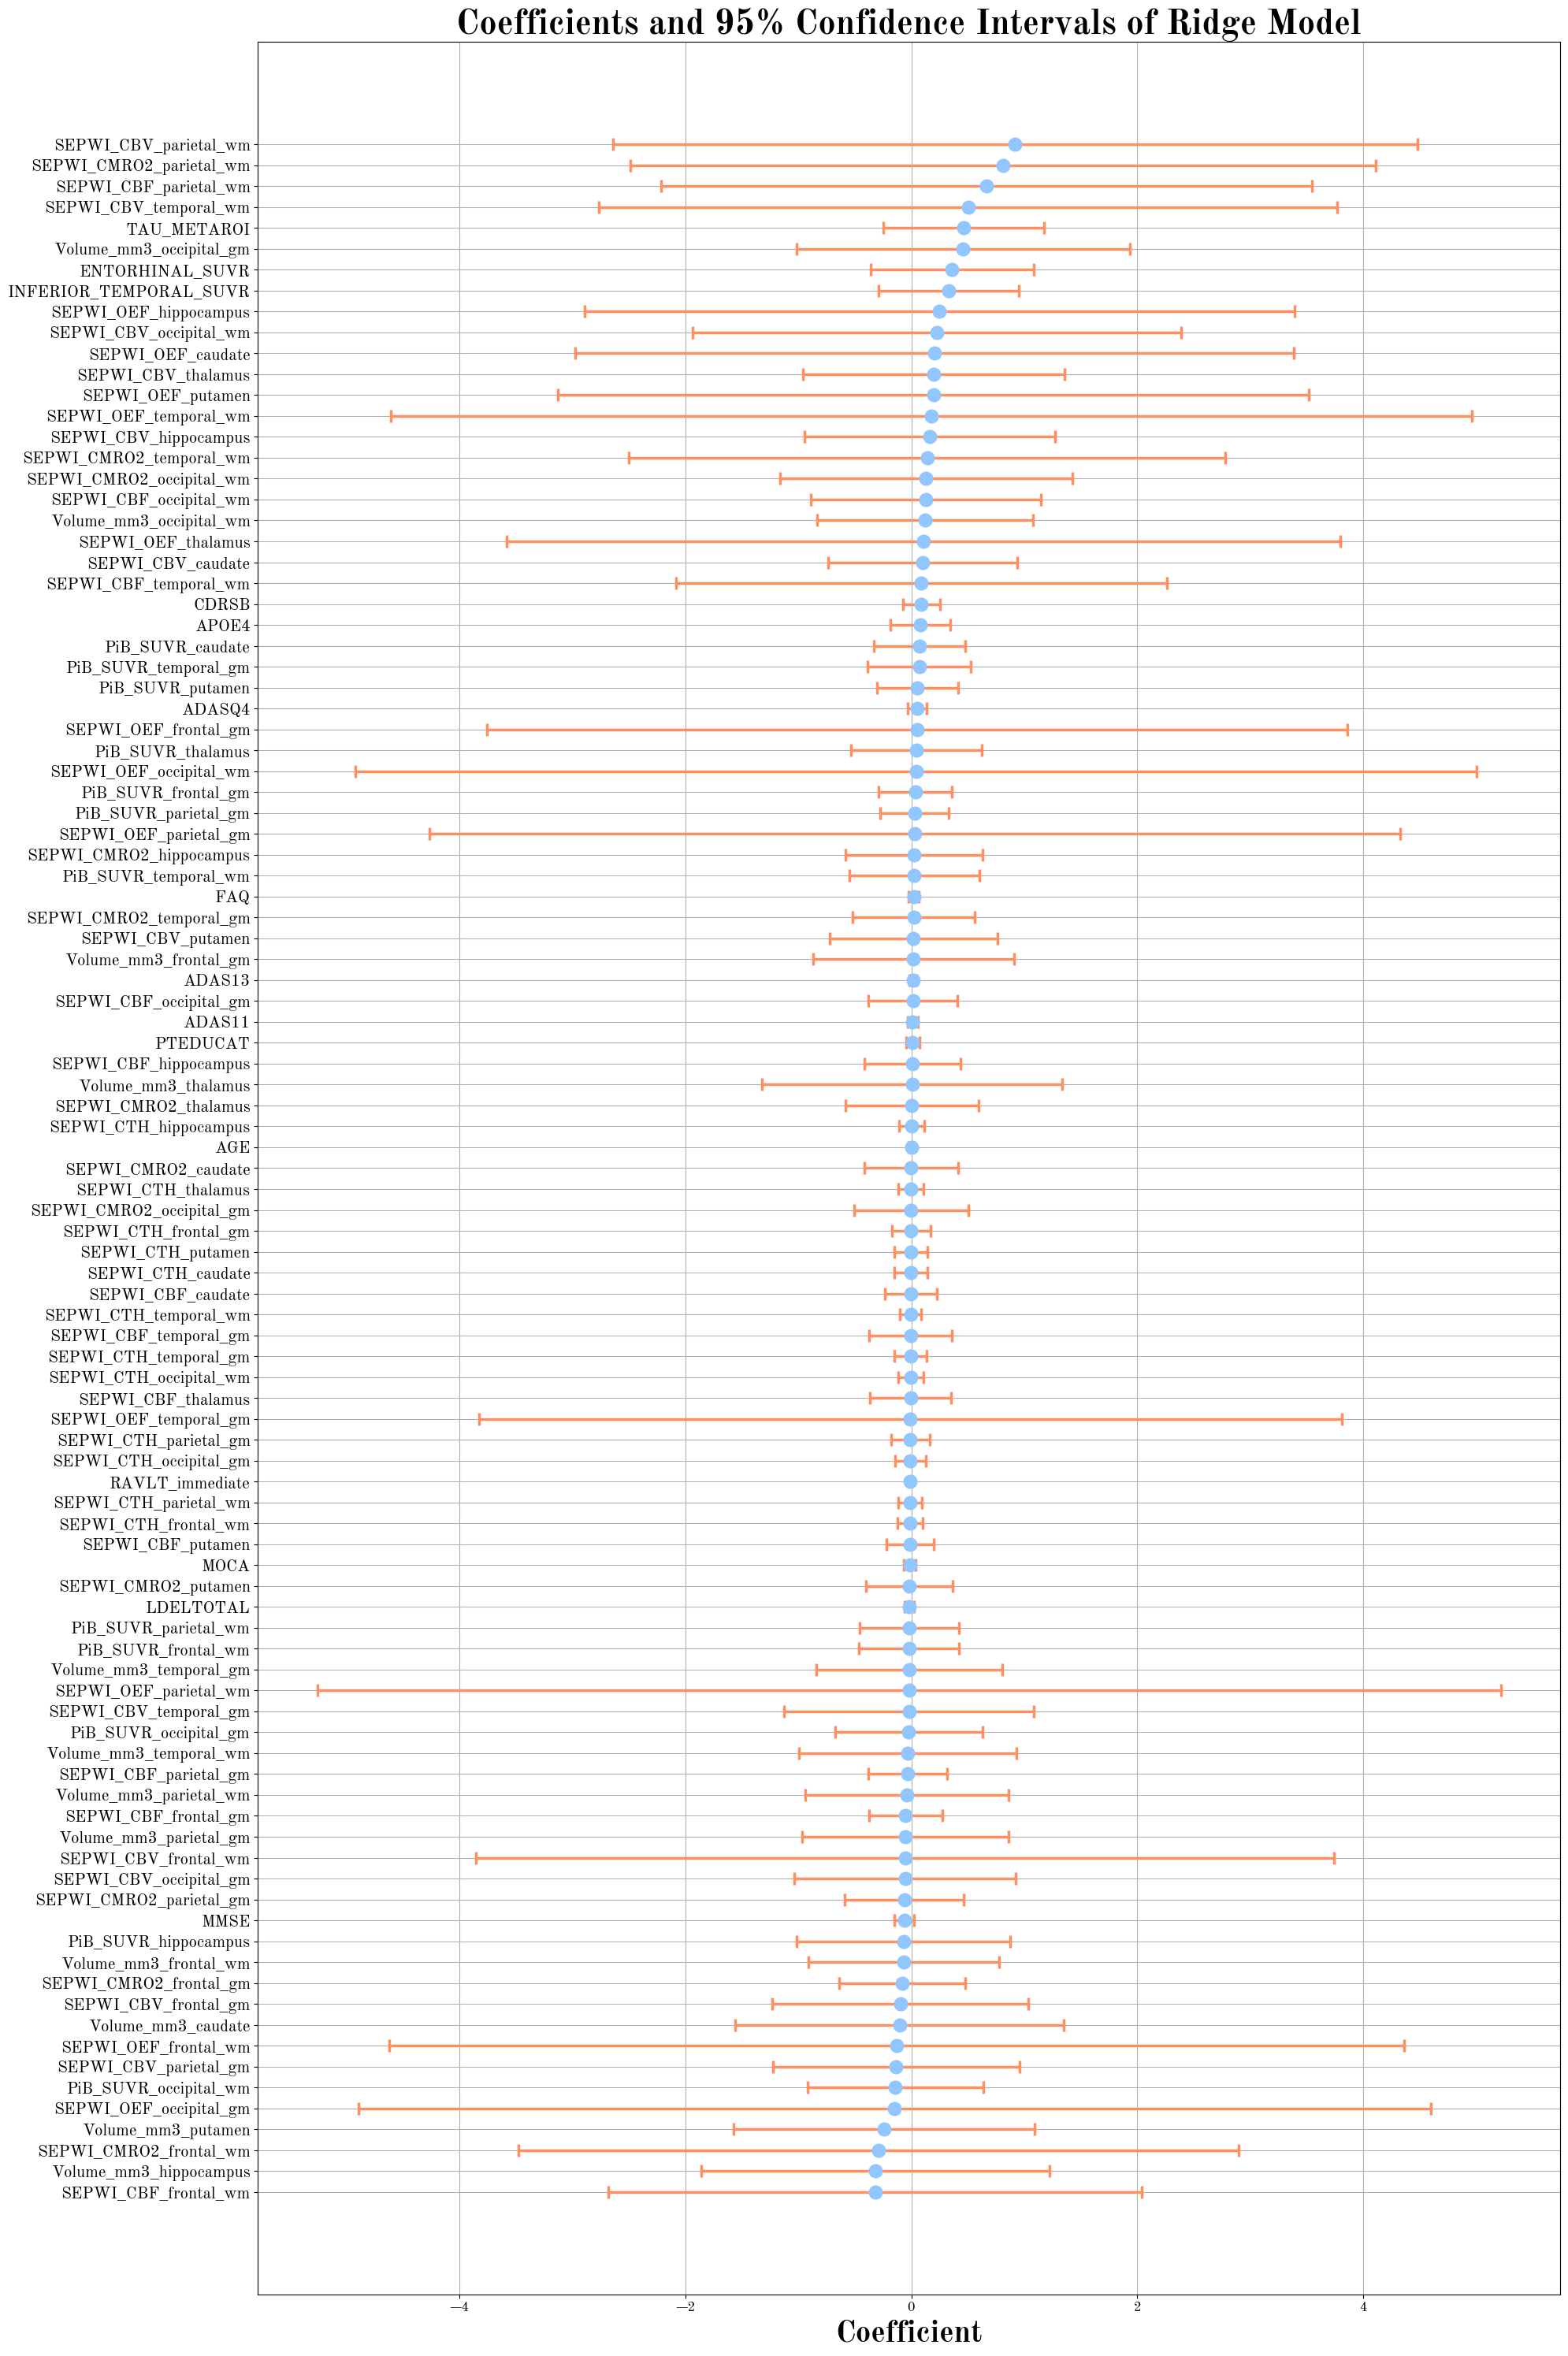

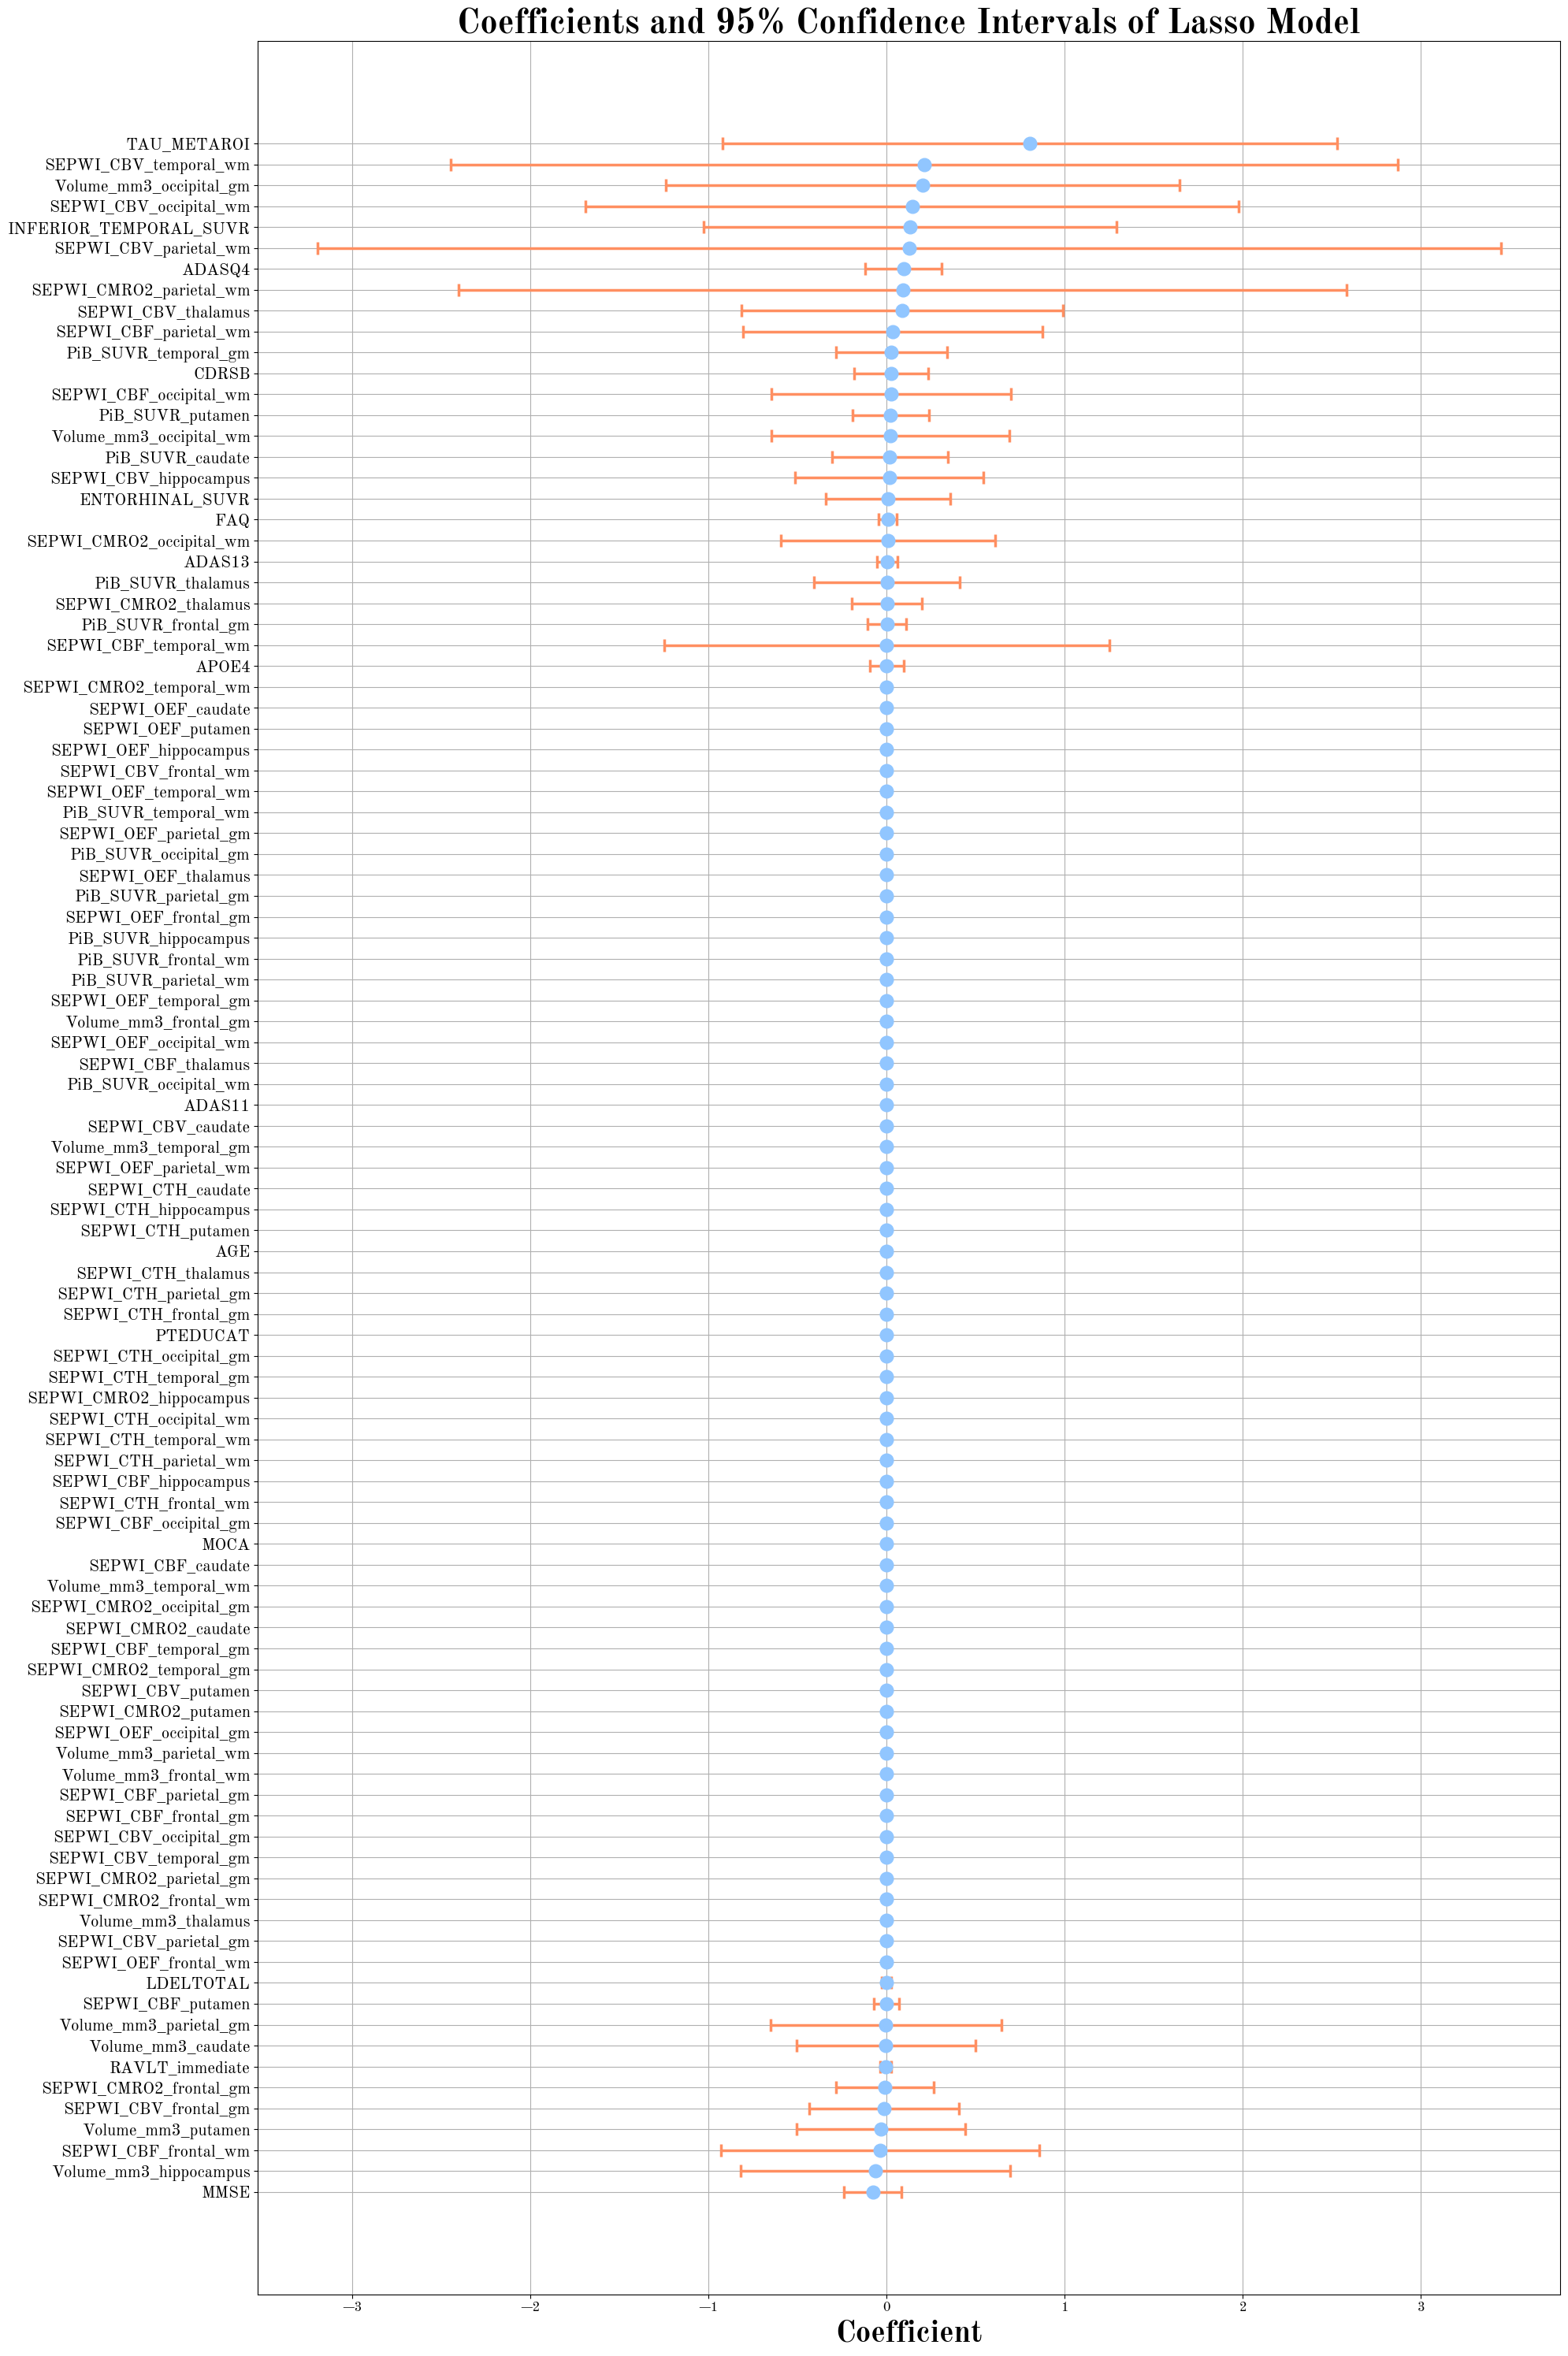

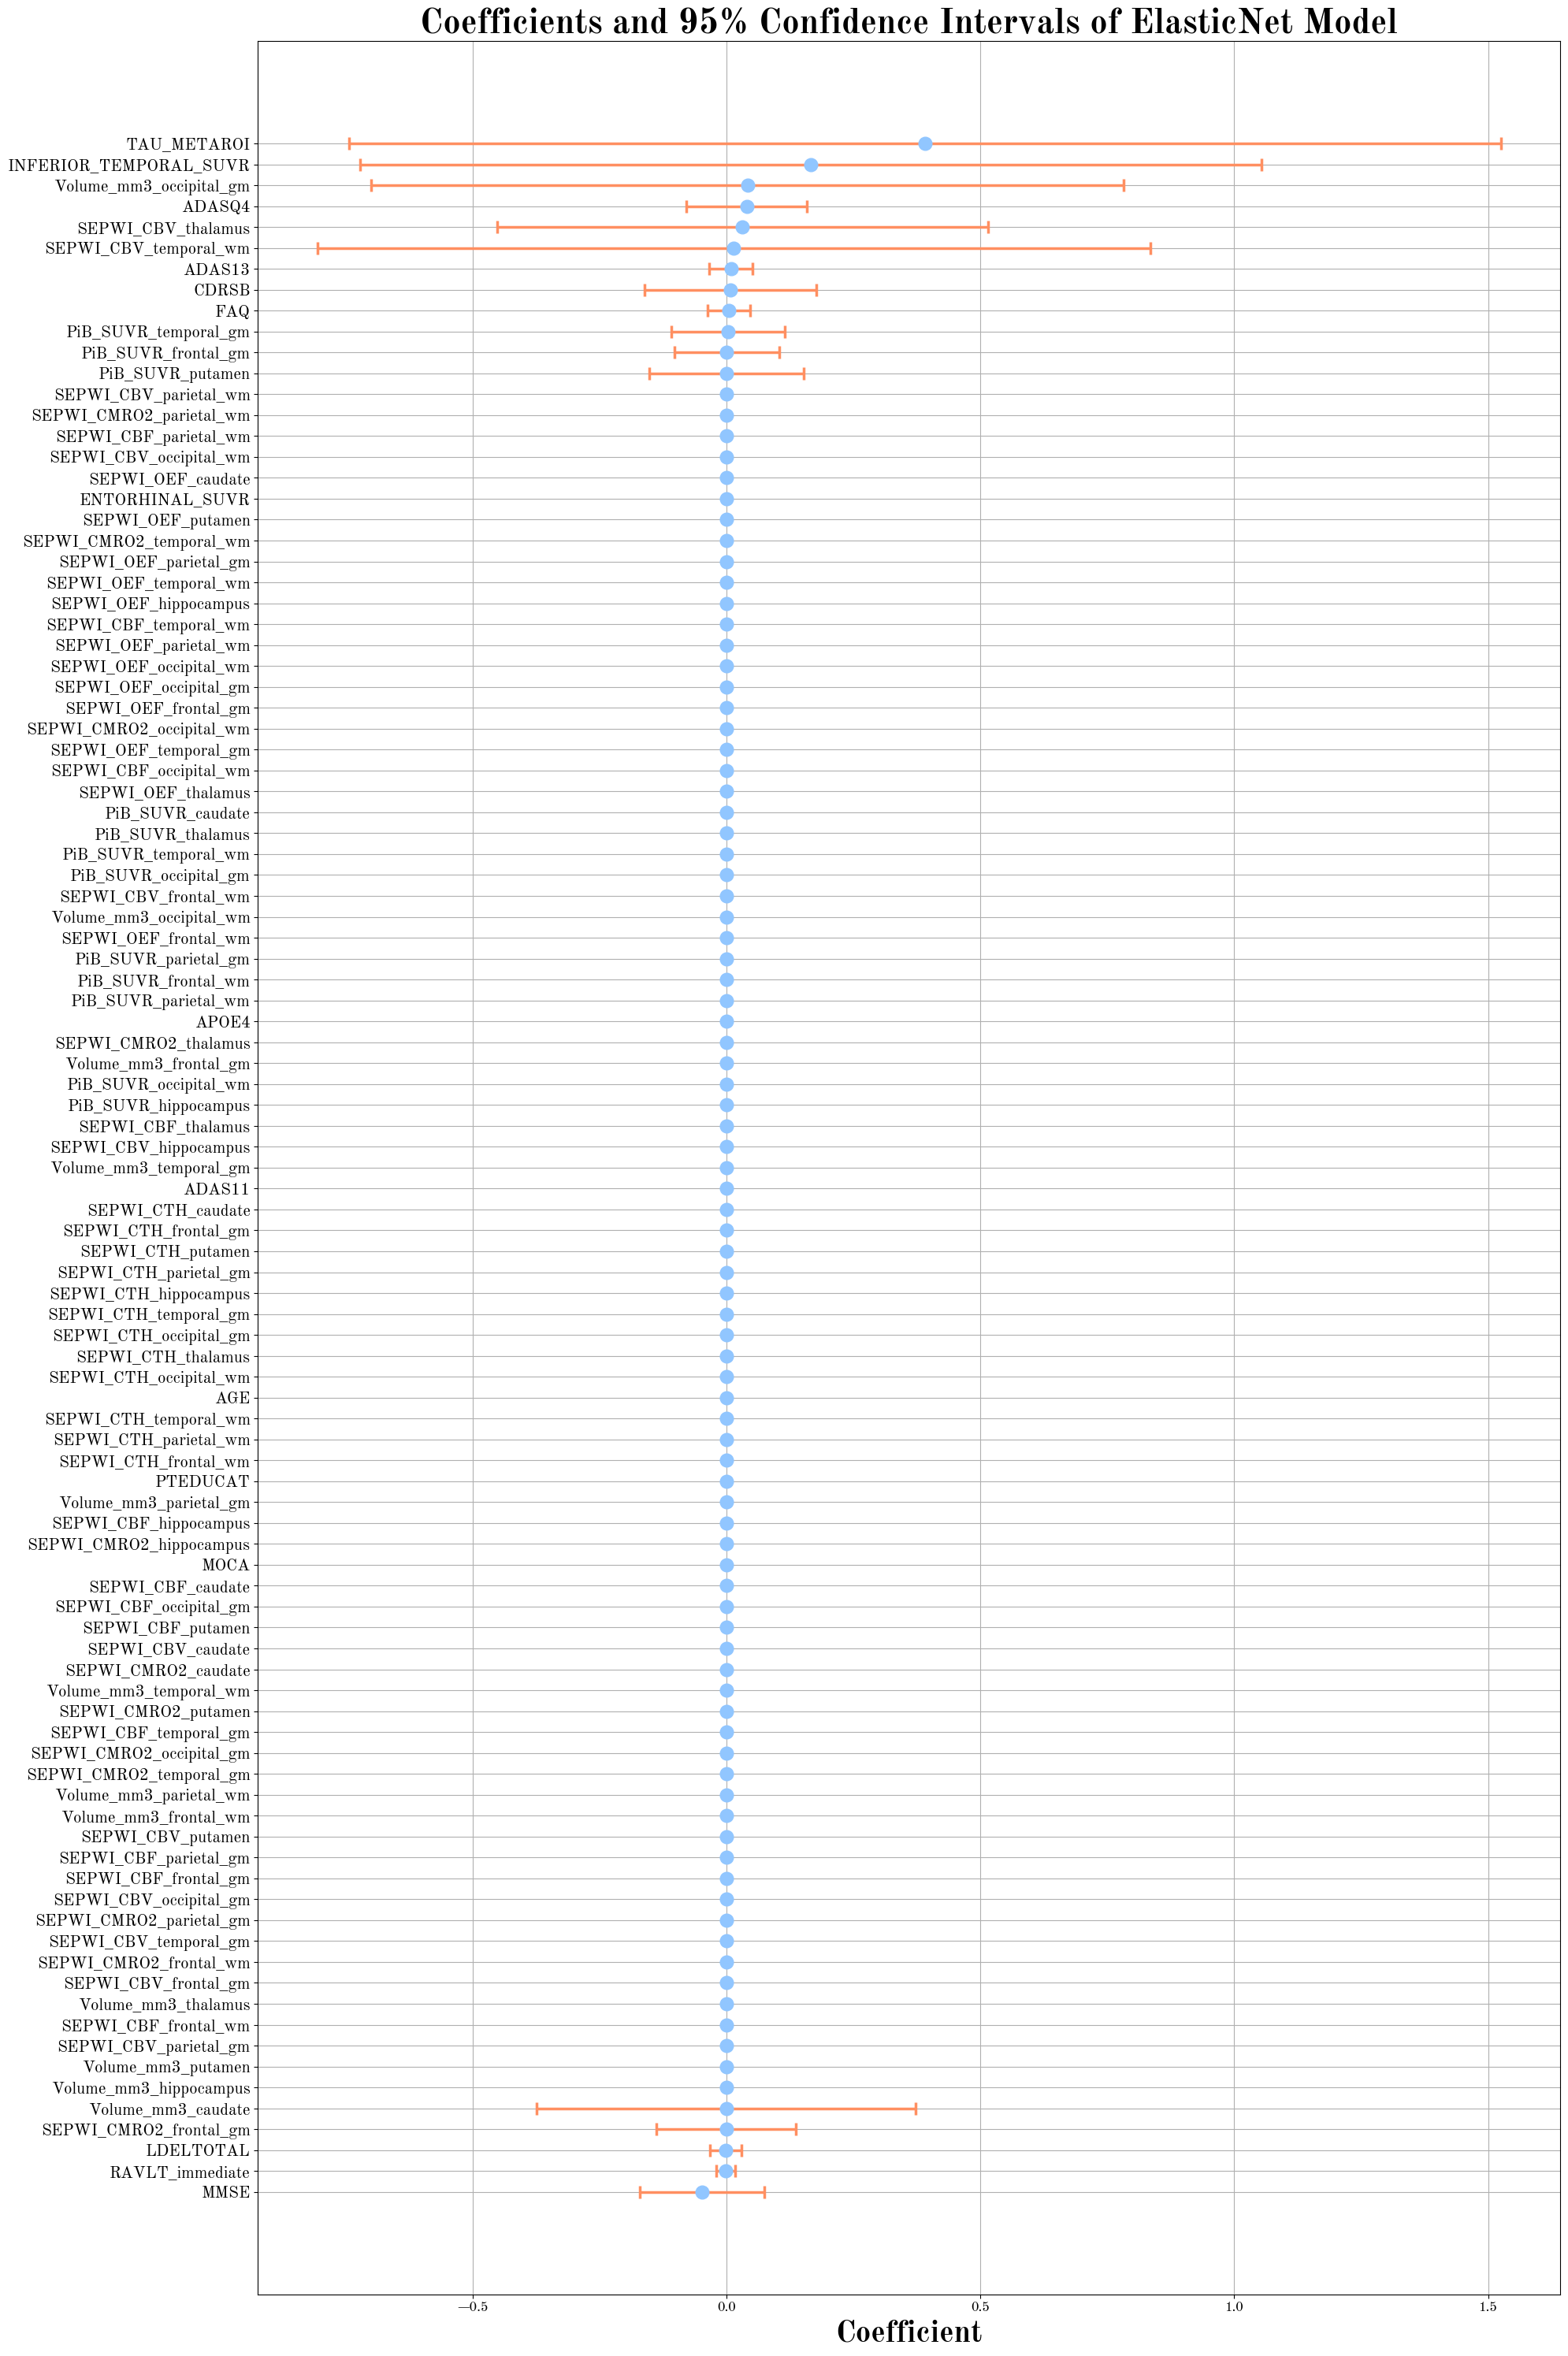

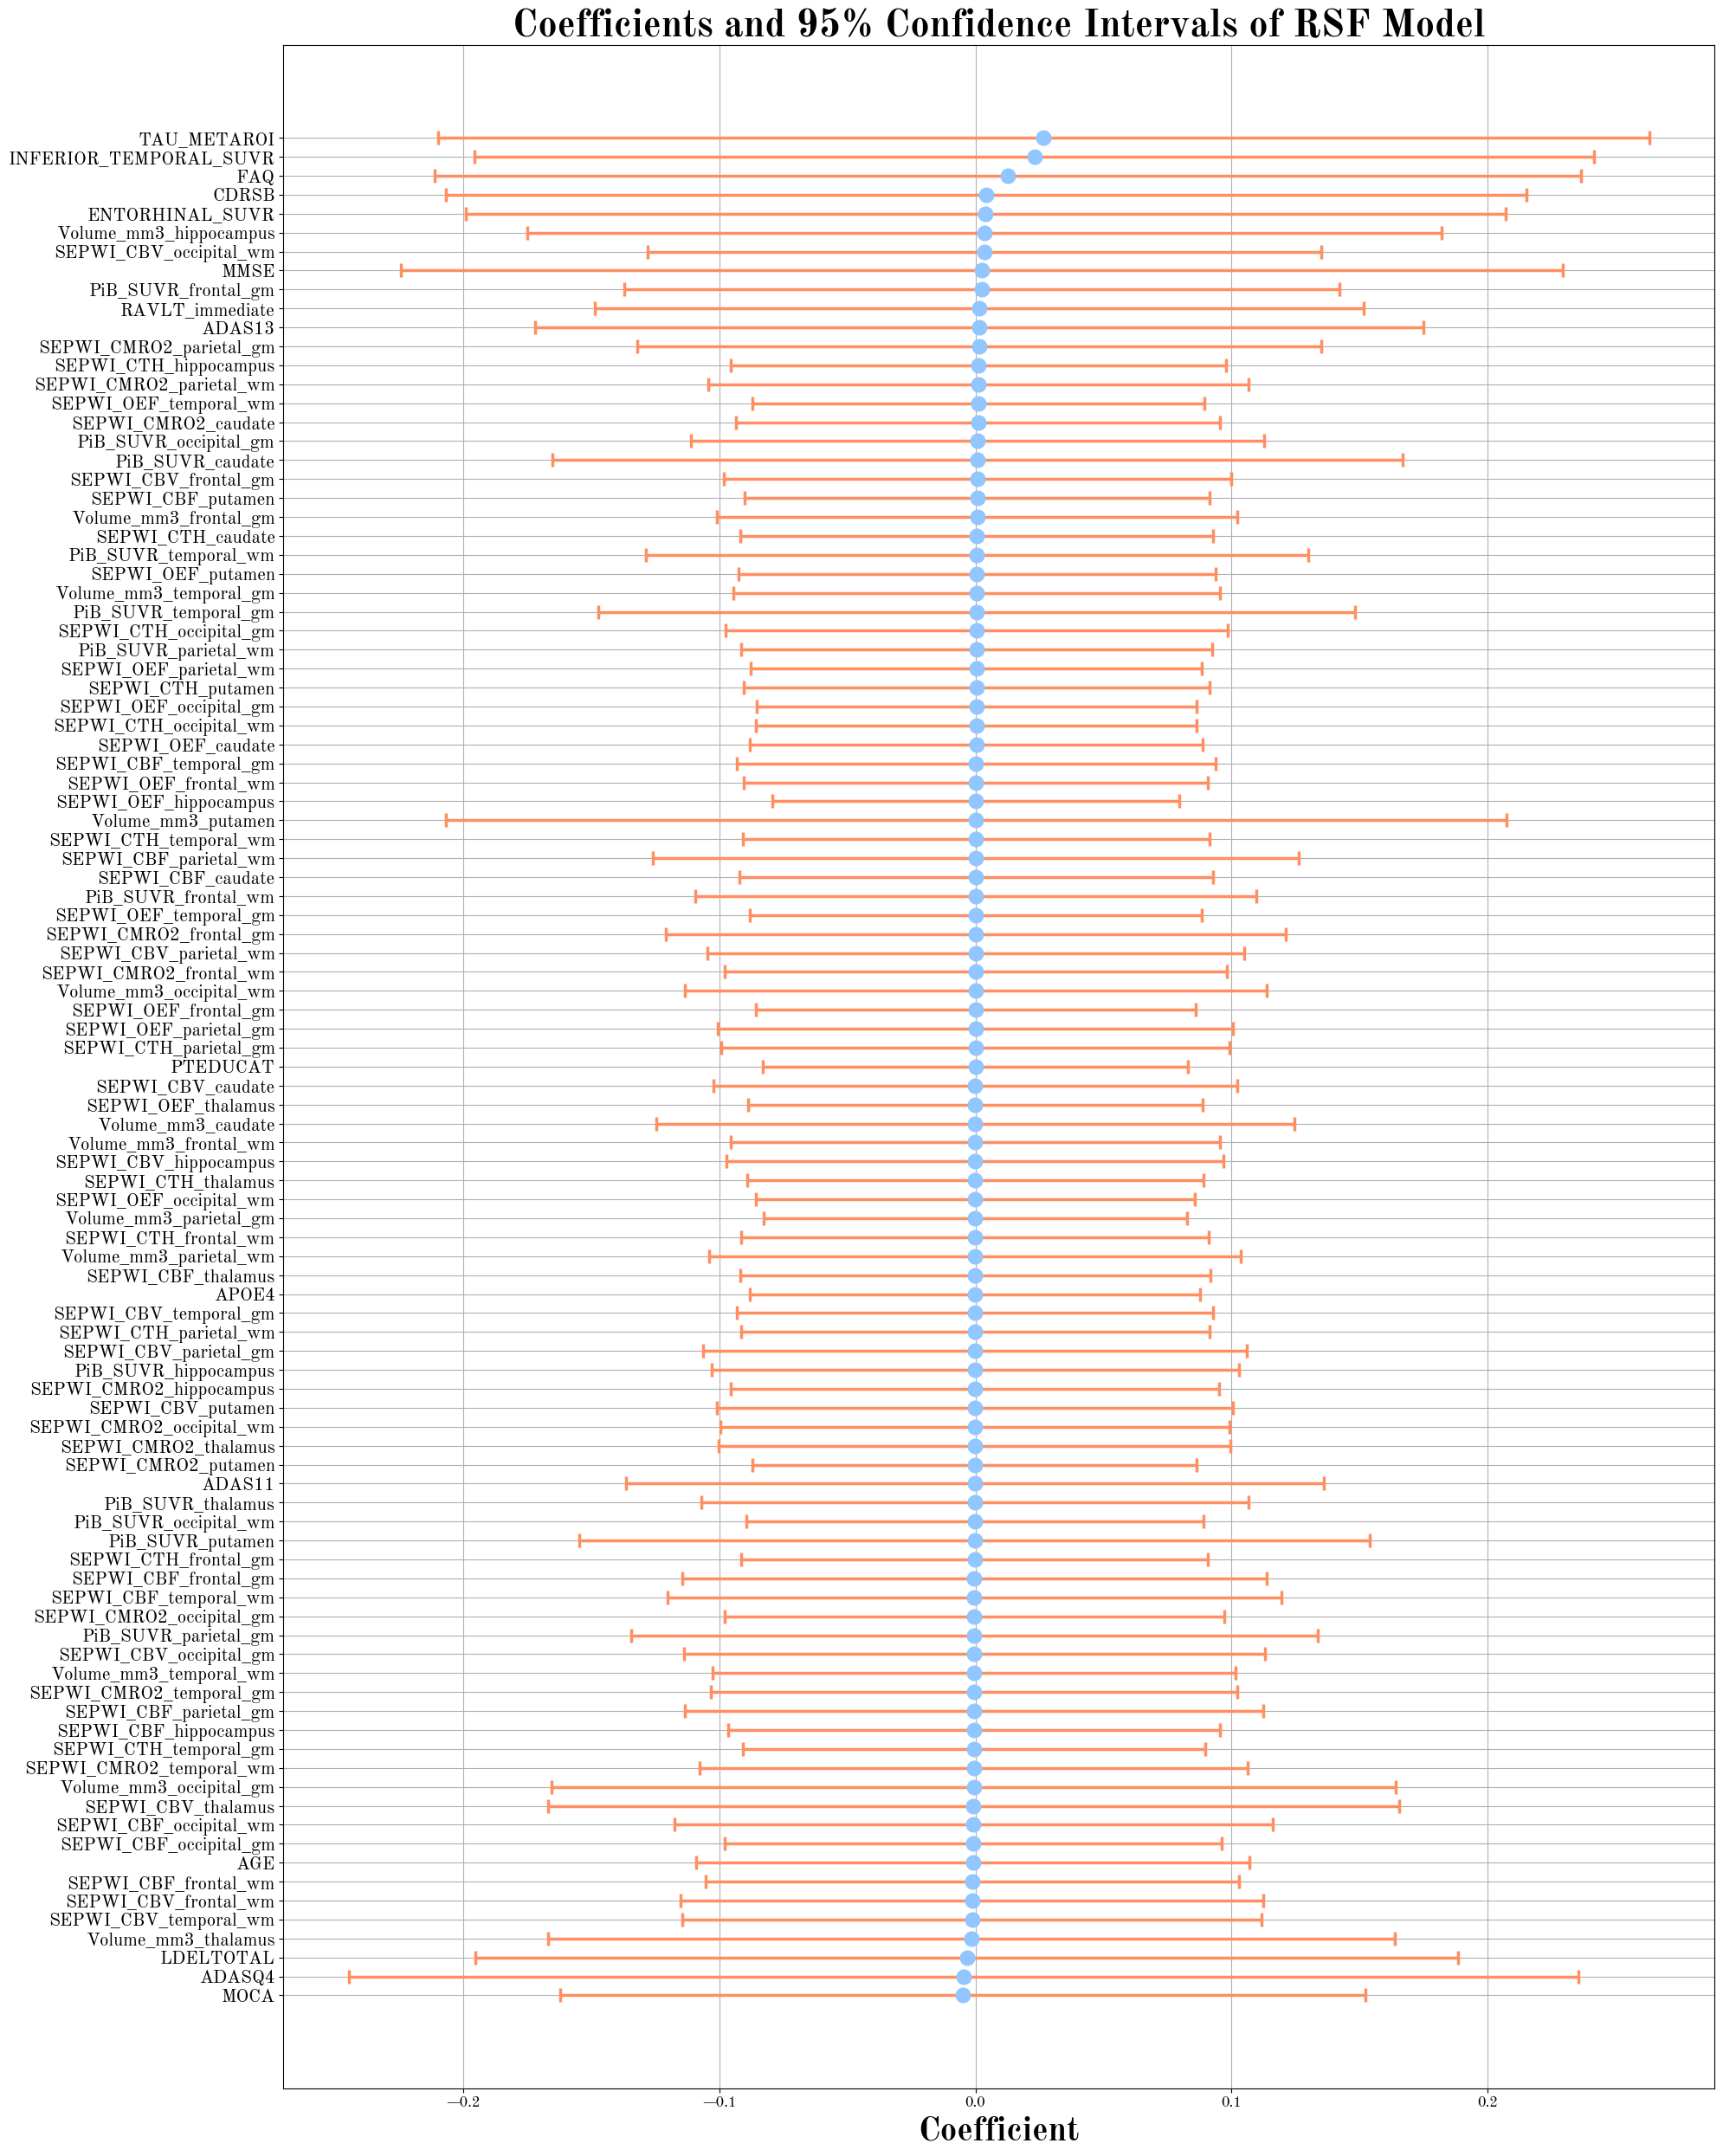

In [21]:
from Utils.plot_functions import plot_errorbar, plot_bar_difference
from sksurv.linear_model import CoxPHSurvivalAnalysis

cph_models_coef = [results_ridge, results_lasso, results_elastic]
labels = ['Ridge', 'Lasso', 'ElasticNet']
path = ['ridge', 'lasso', 'elastic']

model = CoxPHSurvivalAnalysis(alpha=0.1)
x_train, y_train = get_x_y(dfs_train[0], attr_labels=["Event", "M"], pos_label=1)
model.fit(x_train, y_train)

for i, params in enumerate(cph_models_coef):
    params_sorted = params.sort_values(by='coef')
    plot_errorbars(params_sorted['coef'], params_sorted['coef lower 95%'], params_sorted['coef upper 95%'], folder_path + path[i], labels[i], params_sorted, (20, 30))

coef = results_rsf['importance_mean']
ci_lower = results_rsf['importance_ci_lower']
ci_upper = results_rsf['importance_ci_upper']
plot_errorbars(coef, ci_lower, ci_upper, folder_path+ 'rsf', 'RSF', results_rsf, (20,25))

In [22]:
from Utils.plot_functions import get_color_gradient
def plot_bar_difference(model, df_test_inp, label, path):
    df_test = df_test_inp.copy()
    df_test = df_test[df_test['Event'] ==1]
  
    x_test, y_test = get_x_y(df_test, attr_labels=["Event", "M"], pos_label=1)
    pred_surv_funcs = model.predict_survival_function(x_test)
    pred_times = []
    for fn in pred_surv_funcs:
    # Check if there are any points where fn.y <= 0.5
        # print(fn.x[fn.y <= 0.5])
        below_0_5 = fn.x[fn.y <= 0.5]
        if below_0_5.size > 0:
            pred_times.append(below_0_5[0])
        else:
            # Use the maximum time if no probability drops below 0.5
            pred_times.append(fn.x[-1])

    time_diff = pred_times - y_test['M']
    bins = np.arange(-48, 48, 6)
    counts, _ = np.histogram(time_diff, bins=bins)

    plt.figure(figsize=(12, 8))

    plt.bar(bins[:-1], counts, color=get_color_gradient(my_colors[0], my_colors[1], len(bins)), zorder=3, width=3)
    plt.title(f'Difference Between {label} Model Prediction and True Survival Function', fontproperties=prop_bold, fontsize=25)
    plt.xlabel('Difference (months)', fontsize=25, fontproperties=prop_bold)
    plt.ylabel('Count', fontsize=25, fontproperties=prop_bold, labelpad=25)
    
    plt.xticks(bins, fontproperties=prop_regular, fontsize=15)
    plt.yticks(np.arange(0,counts.max()+1),fontproperties=prop_regular, fontsize=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"./results/{path}.pdf")
    plt.show()

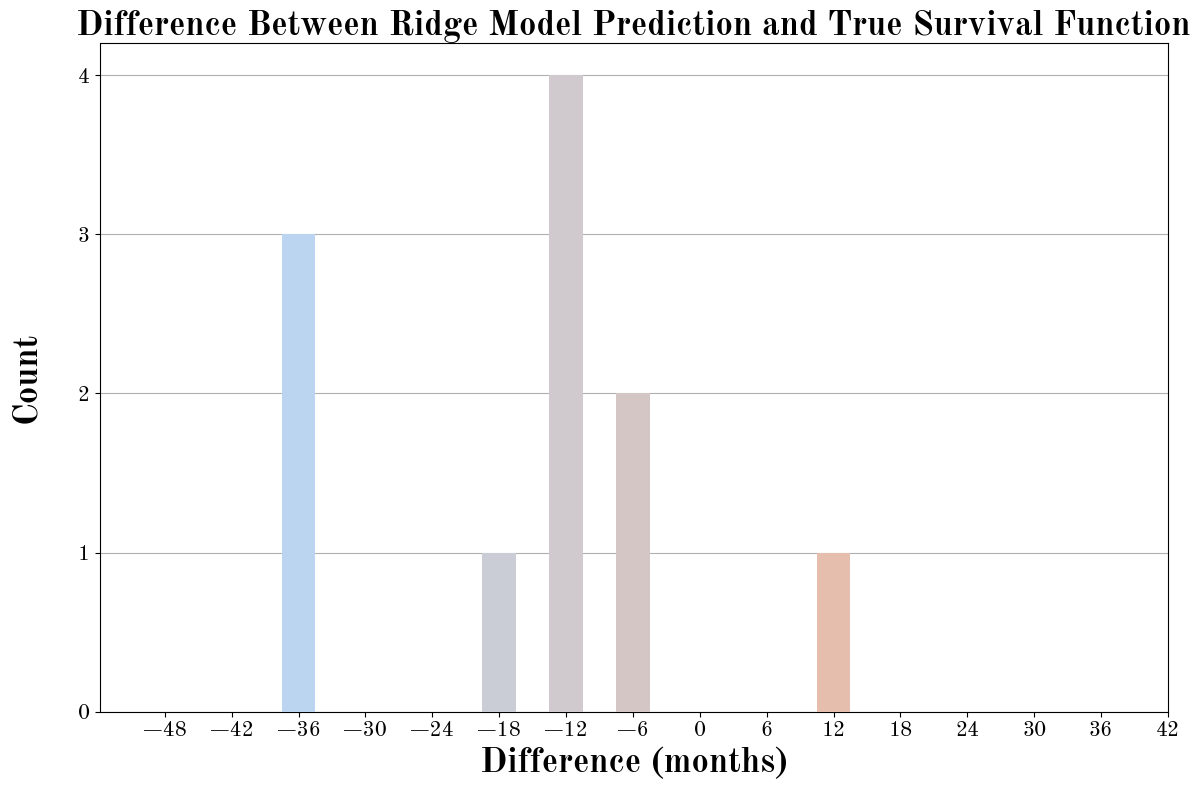

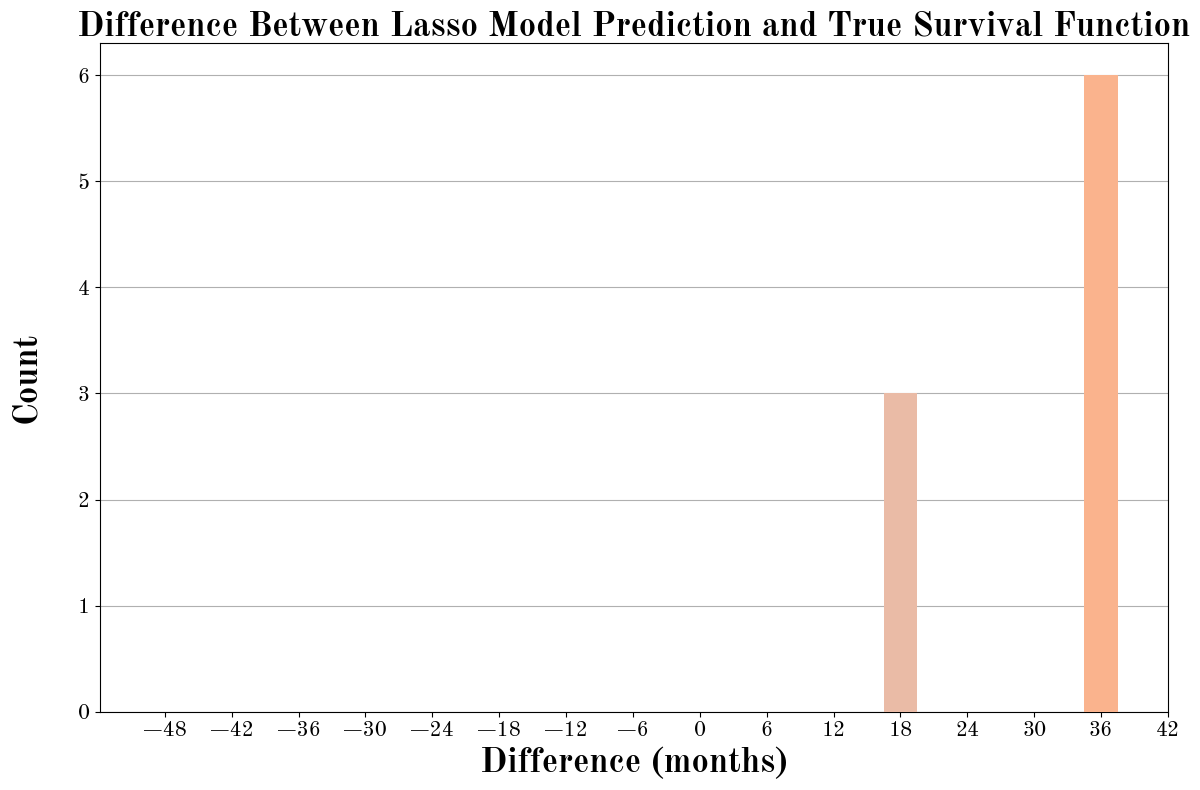

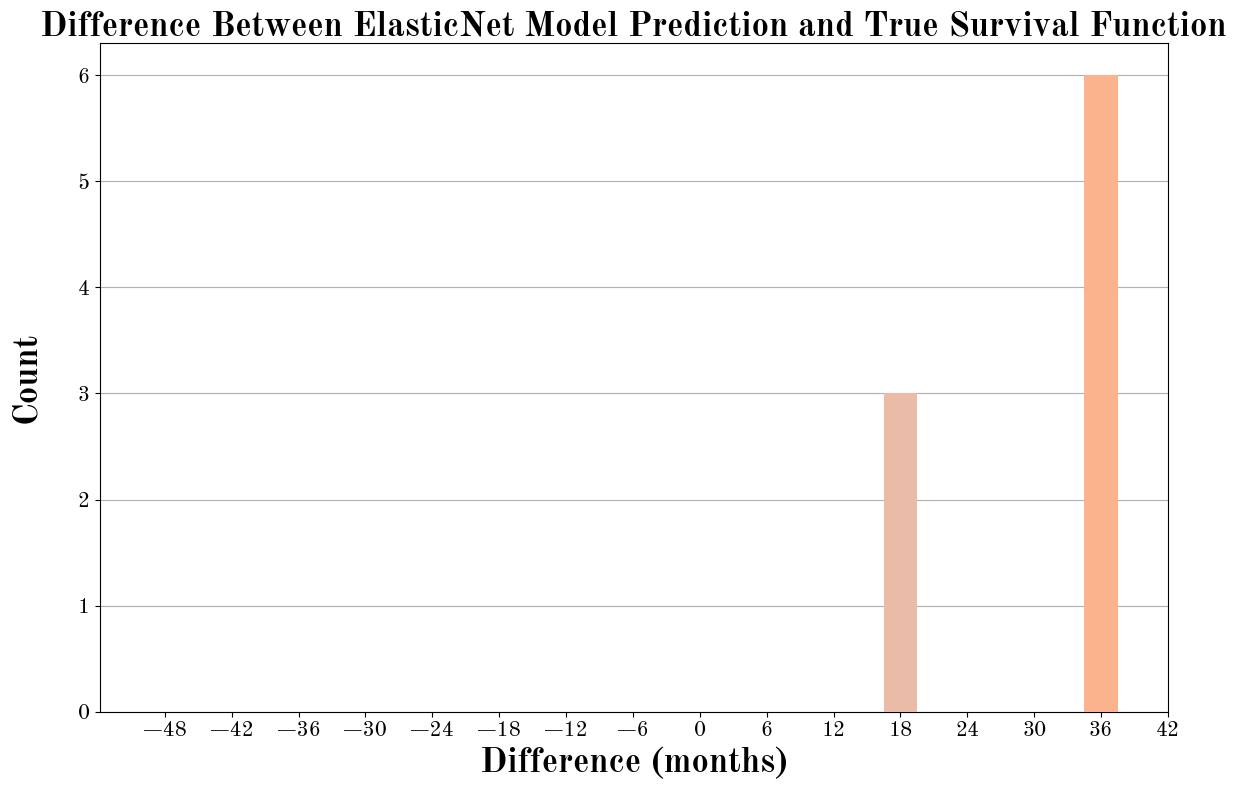

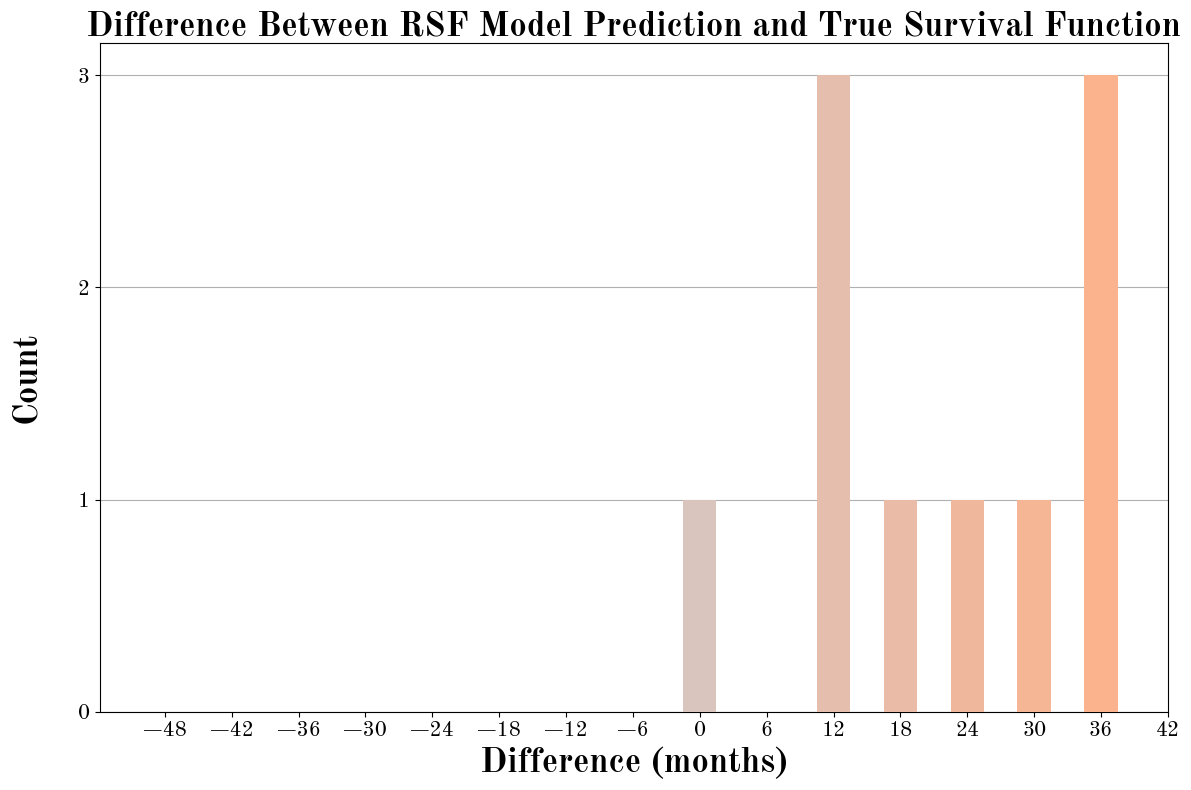

In [23]:
for i, (params, baseline) in enumerate(zip(cph_models_coef, baseline_hazards)):
    model.coef_ = params['coef']
    model.baseline_hazard_ = baseline
    plot_bar_difference(model, dfs_test[0], labels[i], folder_path+path[i]+'_barplot')
plot_bar_difference(rsfs[0][0], dfs_test[0], 'RSF', folder_path + '/rsf_barplot')

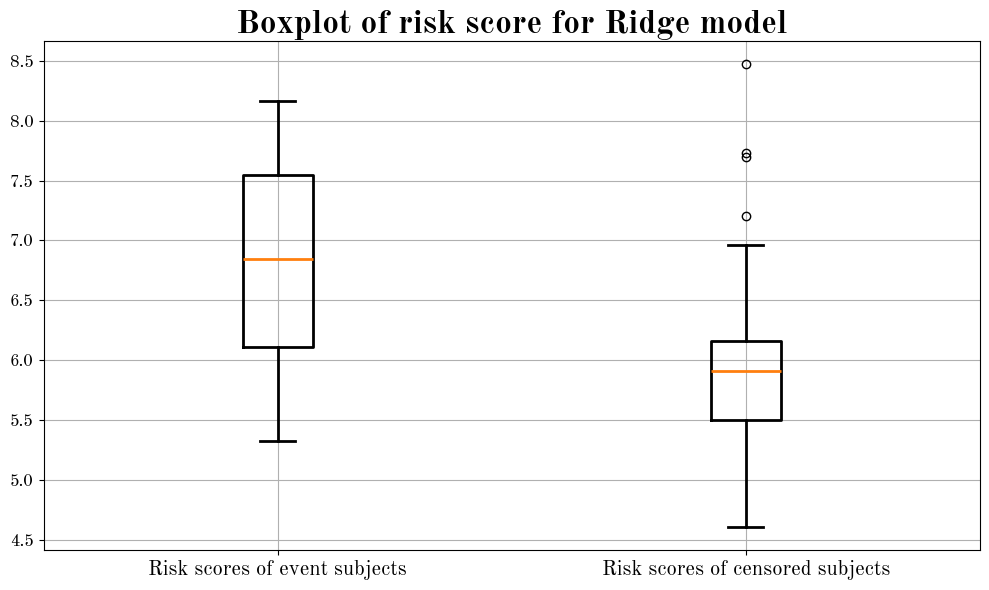

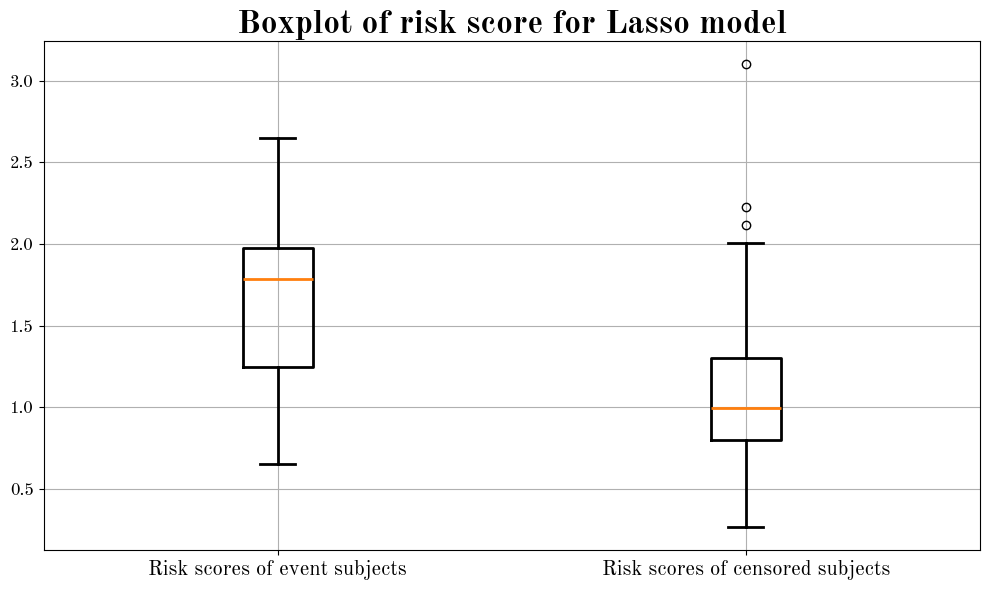

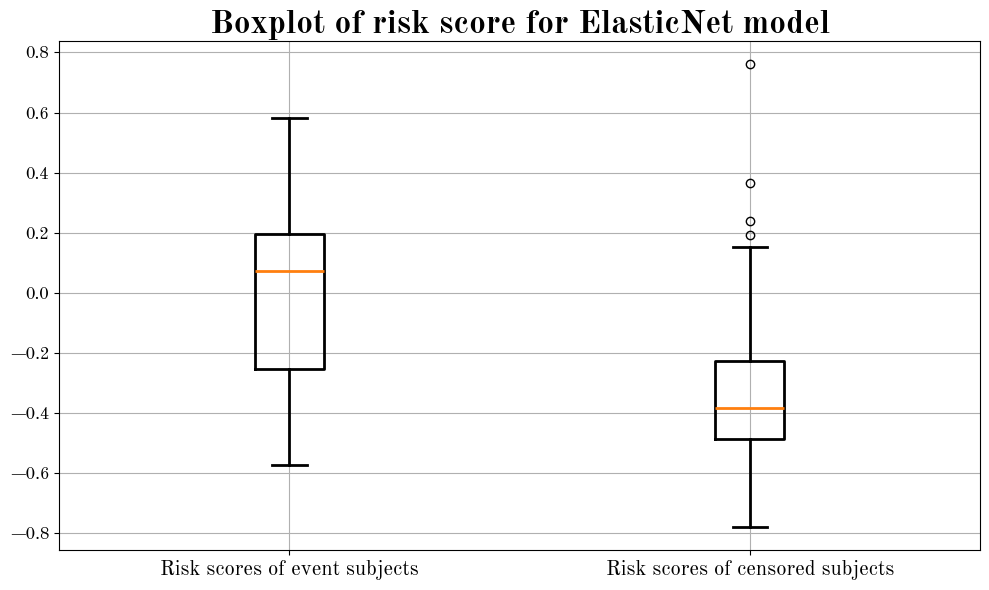

In [24]:
def boxplot_risk_score(model, df_test_inp, label, path):
    df_test_event = df_test_inp.copy()
    df_test_event = df_test_event[df_test_event['Event'] ==1]
    # model.predict_risk_
    x_test, _ = get_x_y(df_test_event, attr_labels=["Event", "M"], pos_label=1)
    risk_scores_event = model.predict(x_test)



    df_test_cen = df_test_inp.copy()
    df_test_cen = df_test_cen[df_test_cen['Event'] ==0]
    # model.predict_risk_
    x_test, _ = get_x_y(df_test_cen, attr_labels=["Event", "M"], pos_label=1)
    risk_scores_cen = model.predict(x_test)
    
    fig = plt.figure(figsize=(10, 6))

    # Create an axis instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    boxprops = dict(linewidth=2)
    whiskerprops = dict(linewidth=2)
    capprops = dict(linewidth=2)
    medianprops = dict(linewidth=2)
    ax.boxplot([risk_scores_event, risk_scores_cen], 
               labels=['Risk scores of event subjects', 'Risk scores of censored subjects'],
               medianprops = medianprops,
               capprops=capprops,
               whiskerprops=whiskerprops,
               boxprops=boxprops)
    
    ax.set_title(f'Boxplot of risk score for {label} model', fontproperties=prop_bold, fontsize=24)



    for label in ax.get_xticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(15)
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(12)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"./results/{path}_box.pdf")
    plt.show()


path = ['ridge', 'lasso', 'elastic']
for i, (params, baseline) in enumerate(zip(cph_models_coef, baseline_hazards)):
    model.coef_ = params['coef']
    model.baseline_hazard_ = baseline
    boxplot_risk_score(model, dfs_test[0], labels[i], folder_path + path[i])